**Predicting Severity:** Predicting the severity of accidents is particularly important because it allows for timely and appropriate responses. By assessing accident severity, responders can allocate resources, prioritize medical treatment, and dispatch appropriate personnel. Predictive models can take into account various factors such as road conditions, weather, vehicle type, and collision type to estimate the likelihood of severe outcomes, helping improve emergency response and medical care.

#### librerias

In [1]:
import os
import re
import string
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import h2o
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from math import radians, sin, cos, sqrt, atan2
from shapely.geometry import Polygon
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from statsmodels.tools.tools import add_constant

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from h2o.automl import H2OAutoML
from tpot import TPOTClassifier


d:\MIAD\despliegue de soluciones\Proyecto_Accidentes_Transito_EU\DSA_Proyecto_AccidentesTransito\.venv\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
# Definir la ruta a la carpeta Data
Data_path = '../Data'

# Cargar los datos
file_path = os.path.join(Data_path, 'US_Accidents_March23_v2.csv')
df = pd.read_csv(file_path)
df.dropna(inplace=True)

# Tomar una muestra aleatoria del 10% de los datos
sample_df = df.sample(frac=0.1, random_state=42)  # random_state asegura reproducibilidad

# Mostrar las primeras filas de la muestra
print("Primeras filas de la muestra (10% del conjunto de datos):")
print('filas / columnas', sample_df.shape)
print(sample_df.head())

Primeras filas de la muestra (10% del conjunto de datos):
filas / columnas (77280, 145)
        Severity  Distance(mi)  Temperature(F)  Wind_Chill(F)  Humidity(%)  \
485866         2         0.000            65.0           65.0         52.0   
518491         2         0.078            83.0           83.0         27.0   
534622         2         0.000            98.6           68.0         29.0   
646447         2         0.010            64.4           74.0        100.0   
311927         3         1.155            52.5           57.0         27.0   

        Pressure(in)  Visibility(mi)  Wind_Speed(mph)  Precipitation(in)  \
485866         29.69            10.0             18.1                0.0   
518491         29.18            10.0             10.0                0.0   
534622         29.81            10.0              9.2                0.0   
646447         30.14            10.0              9.2                0.0   
311927         30.19            10.0              8.1          

In [3]:
def classification_task(model, X_train_scaled, y_train, X_test_scaled, y_test, predic, model_name):
    """
    Evalúa el rendimiento de un modelo de clasificación y devuelve un DataFrame con varias métricas.

    Parámetros:
    - model: objeto del modelo de clasificación entrenado.
    - X_train_scaled: conjunto de datos de entrenamiento escalado.
    - y_train: etiquetas verdaderas del conjunto de entrenamiento.
    - X_test_scaled: conjunto de datos de prueba escalado.
    - y_test: etiquetas verdaderas del conjunto de prueba.
    - predic: predicciones del modelo en el conjunto de prueba.
    - model_name: nombre del modelo, utilizado como índice en el DataFrame de resultados.

    Retorno:
    - perf_df: DataFrame con las métricas de rendimiento del modelo.
    """
    
    # Crear el DataFrame con las métricas de evaluación
    perf_df = pd.DataFrame({
        'Train_Score': model.score(X_train_scaled, y_train),         # Puntaje en el conjunto de entrenamiento
        'Test_Score': model.score(X_test_scaled, y_test),            # Puntaje en el conjunto de prueba
        'Precision_Score': precision_score(y_test, predic, average='weighted'),  # Precisión ponderada
        'Recall_Score': recall_score(y_test, predic, average='weighted'),        # Recall ponderado
        'F1_Score': f1_score(y_test, predic, average='weighted'),               # F1 Score ponderado
        'accuracy': accuracy_score(y_test, predic)                              # Exactitud global
    }, index=[model_name])
    
    return perf_df

In [5]:
# seleccion variable respuesta
X = sample_df.drop('Severity', axis=1)
y= sample_df['Severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


#### RandomForestClassifier

In [6]:
# definicion del modelo
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)  

y_pred = rf_classifier.predict(X_test)
Eval_Rf= classification_task(rf_classifier,X_train, y_train ,X_test ,y_test, y_pred ,'Random Forest')
Eval_Rf

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Random Forest,0.999982,0.87004,0.863534,0.87004,0.851491,0.87004


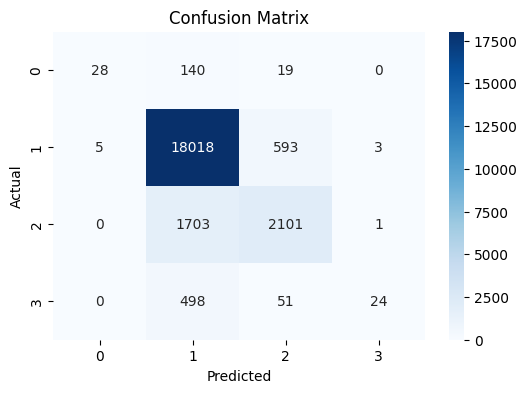

Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.15      0.25       187
           2       0.89      0.97      0.92     18619
           3       0.76      0.55      0.64      3805
           4       0.86      0.04      0.08       573

    accuracy                           0.87     23184
   macro avg       0.84      0.43      0.47     23184
weighted avg       0.86      0.87      0.85     23184



In [7]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


#### XGBoost

In [8]:
(y_train-1).unique()

xgb_classifier = XGBClassifier(objective='multi:softmax',random_state=42)
xgb_classifier.fit(X_train, y_train-1 )

y_pred = xgb_classifier.predict(X_test)
Eval_xgb=classification_task(xgb_classifier,X_train, y_train-1, X_test, y_test-1, y_pred,'XGBoost')
Eval_xgb


,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
XGBoost,0.936317,0.87927,0.870039,0.87927,0.87157,0.87927


Accuracy: 0.88


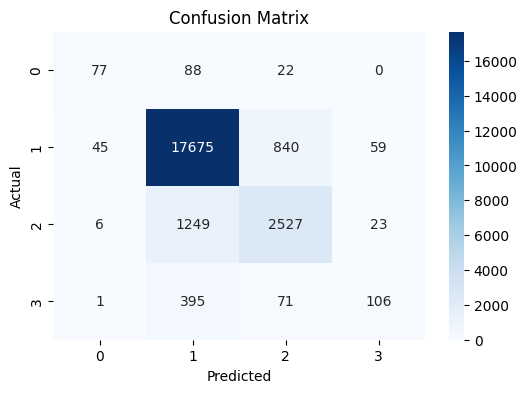

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.41      0.49       187
           1       0.91      0.95      0.93     18619
           2       0.73      0.66      0.70      3805
           3       0.56      0.18      0.28       573

    accuracy                           0.88     23184
   macro avg       0.70      0.55      0.60     23184
weighted avg       0.87      0.88      0.87     23184



In [9]:
accuracy = accuracy_score(y_test-1, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test-1, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test-1, y_pred)
print("Classification Report:")
print(class_report)